Notes
- Predator should have several yuck vectors
- Predator not selected strongly enough against for eating venomous prey

In [126]:
import numpy as np
from tqdm import tqdm
import datetime 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, poisson
from scipy.special import softmax
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from matplotlib import animation
from IPython.display import HTML
import pandas as pd


def generate(num_predators, num_venomous_prey, num_mimics, d=2, venom_const=0.5):

    predators_detectors_initial_mean = np.array([1 / np.sqrt(2) for _ in range(d)])
    predators_detectors_initial_cov = 0.4**2 * np.eye(d)
    
    venomous_signals_initial_mean = np.array([-1 / np.sqrt(2), *[-1 / np.sqrt(2) for _ in range(d-1)]])
    venomous_signals_initial_cov = 0.4**2 * np.eye(d)
    
    mimic_signals_initial_mean = np.array([*[-1 / np.sqrt(2) for _ in range(d-1)], 1 / np.sqrt(2)])
    mimic_signals_initial_cov = 0.4**2 * np.eye(d)

    detectors = np.random.multivariate_normal(mean=predators_detectors_initial_mean,
                                              cov=predators_detectors_initial_cov,
                                              size=num_predators)
    venomous_signals = np.random.multivariate_normal(mean=venomous_signals_initial_mean,
                                                     cov=venomous_signals_initial_cov,
                                                     size=num_venomous_prey)
    mimic_signals = np.random.multivariate_normal(mean=mimic_signals_initial_mean,
                                                  cov=mimic_signals_initial_cov,
                                                  size=num_mimics)
    
    signals = np.vstack((venomous_signals, mimic_signals))
    
    risk_tols = np.random.exponential(scale=1000., size=num_predators)
    venom_levels = np.concatenate((np.zeros(num_venomous_prey) + venom_const, np.zeros(num_mimics)))

    return detectors, signals, risk_tols, venom_levels

def similarity(detectors, signals, phenotype_type='vector'):
    match phenotype_type:
        case 'vector':
            dist = np.linalg.norm(detectors[:, np.newaxis] - signals, axis=2)
            return - dist**2
            # cossim = cosine_similarity(detectors, signals)
            # return cossim
        case 'bitstring':
            d = signals.shape[1]
            hamming_distances = np.sum(detectors[:, np.newaxis] != signals, axis=2)
            return 1 - hamming_distances/d
        case _:
            raise NotImplementedError

def calculate_preference_matrix(detectors, signals, risk_tols, phenotype_type='vector'):
    similarity_matrix = similarity(detectors, signals, phenotype_type=phenotype_type) 
    return 1 - np.exp(similarity_matrix / risk_tols[:, np.newaxis])
    
def calculate_predation_matrix(detectors, signals, risk_tols, handling_time, attack_freq, phenotype_type='vector'):
    preference_matrix = calculate_preference_matrix(detectors, signals, risk_tols, phenotype_type)
    n_prey = preference_matrix.shape[1]
    n_effective_prey = preference_matrix.sum(1)
    intake_rates = attack_freq / (1 + attack_freq * handling_time * n_effective_prey)
    return intake_rates[:, None] * preference_matrix

def sample_predators(predation_matrix, venom_levels, pred_conversion_ratio):
    num_predators = predation_matrix.shape[0]
    E = predation_matrix / predation_matrix.sum(0)
    fitnesses = (E * (1 - venom_levels) * pred_conversion_ratio - E * venom_levels).sum(1)
    means = fitnesses
    means[means < 0] = 0
    counts = np.random.poisson(means)
    return np.repeat(np.arange(num_predators), counts)

def sample_prey(predation_matrix, prey_conversion_ratio, venom_levels):
    nv = (venom_levels > 0).sum()
    nm = (venom_levels == 0).sum()
    num_prey = (venom_levels > 0) * nv + (venom_levels == 0) * nm
    fitnesses = prey_conversion_ratio / num_prey * np.prod(1 - predation_matrix, 0)  
    means = fitnesses.copy()
    means[means < 0] = 0
    counts = np.random.poisson(means)
    return np.repeat(np.arange(nv + nm), counts)

def phenotype_crossover(phenotypes, parents, phenotype_type='vector'):

    # phenotypes can be signals or detectors
    assert len(parents) % 2 == 0, 'Crossover not implemented yet for odd numbers of parents'
    parent_phenotypes = phenotypes[parents]
    child_phenotypes = np.zeros_like(parent_phenotypes)
    match phenotype_type:
        case 'vector':
            interpolation_values = np.random.rand(parent_phenotypes.shape[0] // 2)[:, np.newaxis]
            child_phenotypes[::2]  = interpolation_values * parent_phenotypes[::2] \
                                    + (1 - interpolation_values) * parent_phenotypes[1::2]
            child_phenotypes[1::2] = (1 - interpolation_values) * parent_phenotypes[::2] \
                                    + interpolation_values * parent_phenotypes[1::2]
            return child_phenotypes
        case 'bitstring':
            raise NotImplementedError
        case _:
            raise NotImplementedError
        

def phenotype_mutate(phenotypes, mutation_rate=0.01, phenotype_type='vector'):
    match phenotype_type:
        case 'vector':
            return phenotypes + np.random.normal(scale=mutation_rate, size=phenotypes.shape)
        case 'bitstring':
            raise NotImplementedError
        case _:
            raise NotImplementedError

def impose_periodic_boundary(vectors, boundary=5):
    """
    Imposes periodic boundary conditions on an array of 2D vectors.
    
    Parameters:
    vectors (np.array): Array of shape (n, 2) containing 2D vectors.
    boundary (float): The boundary value for both x and y dimensions. Default is 5.
    
    Returns:
    np.array: Array of shape (n, 2) with periodic boundary conditions applied.
    """
    # Ensure the input is a numpy array
    vectors = np.array(vectors)
    
    # Apply periodic boundary conditions
    vectors = np.mod(vectors + boundary, 2 * boundary) - boundary
    
    return vectors


def update(detectors, signals, risk_tols, venom_levels, num_venomous, 
           handling_time=1, attack_freq=2, predator_conversion_ratio=1000, prey_conversion_ratio=10000,
           mutation_rate=0.001, phenotype_type='vector'):

    assert np.all(venom_levels[num_venomous:] == 0), 'A mimic has a non-zero venom level'

    predation_matrix = calculate_predation_matrix(detectors, signals, risk_tols, handling_time, attack_freq, phenotype_type=phenotype_type)

    predator_children = sample_predators(predation_matrix, venom_levels, predator_conversion_ratio)
    prey_children = sample_prey(predation_matrix, prey_conversion_ratio, venom_levels)
    
    predator_children_detectors = detectors[predator_children]
    prey_children_signals = signals[prey_children]
    
    predator_childrens_detectors = phenotype_mutate(predator_children_detectors, mutation_rate=mutation_rate, phenotype_type=phenotype_type)
    prey_childrens_signals = phenotype_mutate(prey_children_signals, mutation_rate=mutation_rate, phenotype_type=phenotype_type)

    predator_children_detectors = impose_periodic_boundary(predator_childrens_detectors, 2)
    prey_childrens_signals = impose_periodic_boundary(prey_childrens_signals, 2)
    
    predator_childrens_risk_tols = phenotype_mutate(risk_tols[predator_children], mutation_rate=mutation_rate, phenotype_type=phenotype_type)
    predator_childrens_risk_tols = abs(predator_childrens_risk_tols)
    # prey_childrens_venoms = phenotype_mutate(venom_levels[prey_children], mutation_rate=mutation_rate, phenotype_type=phenotype_type)
    # prey_childrens_venoms[prey_childrens_venoms > 0.9999] = 0.9999
    # prey_childrens_venoms[prey_childrens_venoms < 0.0001] = 0.0001
    # prey_childrens_venoms[venom_levels[prey_children] == 0] = 0

    prey_childrens_venoms = venom_levels[prey_children]

    new_num_venomous = (prey_childrens_venoms > 0).sum()

    return predator_childrens_detectors, prey_childrens_signals, predator_childrens_risk_tols, prey_childrens_venoms, new_num_venomous

In [133]:
def plot(detectors_history, nv_history, signals_history, smooth=10):

    fig, ax = plt.subplots(figsize=(8,4))
    n_pred = []
    n_mim = []
    n_ven = []
    for t in range(len(detectors_history)):
        n_pred.append(len(detectors_history[t]))
        n_ven.append(nv_history[t])
        n_mim.append(len(signals_history[t]) - n_ven[-1])
    
    ax.plot(n_pred, '-', c='red', alpha=0.2)
    ax.plot(n_mim, '-', c='green', alpha=0.2)
    ax.plot(n_ven, '-', c='orange', alpha=0.2)

    n_pred_smooth = pd.Series(n_pred).rolling(smooth).mean()
    n_mim_smooth = pd.Series(n_mim).rolling(smooth).mean()
    n_ven_smooth = pd.Series(n_ven).rolling(smooth).mean()

    n_pred_smooth.plot(ax=ax, c='red', label='Predator')
    n_mim_smooth.plot(ax=ax, c='green', label='Mimic')
    n_ven_smooth.plot(ax=ax, c='orange', label='Model')
    
    
    ax.set_xlabel("Generation")
    ax.set_ylabel("Population")
    ax.legend()

    return ax

import numpy as np
from tqdm import tqdm
from numba import jit

@jit(nopython=True)
def centroid(points1, points2):
    diff = np.mean(points1) - np.mean(points2)
    return np.sqrt(diff * diff)  # This is equivalent to np.abs(diff)

@jit(nopython=True)
def bootstrap_centroids(m_sigs, v_sigs, n_bootstraps=1000):
    bootstraps = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        m_sigs_idx = np.random.choice(len(m_sigs), size=len(m_sigs))
        v_sigs_idx = np.random.choice(len(v_sigs), size=len(v_sigs))
        bootstraps[i] = centroid(m_sigs[m_sigs_idx], v_sigs[v_sigs_idx])
    return bootstraps

def plot_overlap(detectors_history, signals_history, ax, bootstrap=False):

    overlap = np.zeros(len(detectors_history))
    if bootstrap:
        hi = np.zeros(len(detectors_history))
        lo = np.zeros(len(detectors_history))
    
    for t in tqdm(range(len(detectors_history))):
        signals = signals_history[t]
        nv = nv_history[t]
        m_sigs = signals[nv:]
        v_sigs = signals[:nv]
        
        overlap[t] = centroid(m_sigs, v_sigs)
    
        if bootstrap:
            bootstraps = bootstrap_centroids(m_sigs, v_sigs)
            hi[t] = np.quantile(bootstraps, 0.975)
            lo[t] = np.quantile(bootstraps, 0.025)
    
    tx = ax.twinx()
    tx.plot(overlap, '--k', lw=0.5)
    if bootstrap:
        tx.fill_between(range(len(hi)), hi, lo, alpha=0.2, color='k')

In [141]:
# Initialize population parameters
num_predators = 50
num_venomous_prey = 500
num_mimics = 500
d = 2
venomosity = 0.3

detectors, signals, risk_tols, venom_levels = generate(num_predators, num_venomous_prey, num_mimics, d, venomosity)

In [142]:
num_generations = 2000
ht = 0.1
af = 0.5
mutation_rate = 0.01
predator_conversion_ratio = 0.25
prey_pop = 1000

detectors_history    = []
signals_history      = []
risk_tols_history    = []
venom_levels_history = []
nv_history = []

detectors_history.append(detectors)
signals_history.append(signals)
risk_tols_history.append(risk_tols)
venom_levels_history.append(venom_levels)
nv_history.append(num_venomous_prey)

for t in tqdm(range(num_generations)):

    # if t % 100 == 0:
    #     print(f"\n Gen {t}")
    #     print(f"Predators left: {len(detectors_history[t])}")
    #     print(f"Venomous Prey left: {nv_history[t]}")
    #     print(f"Mimic Prey left: {len(signals_history[t]) - nv_history[t]}")
    
    d, s, r, v, nv = update(
        detectors_history[t], 
        signals_history[t], 
        risk_tols_history[t], 
        venom_levels_history[t], 
        nv_history[t], 
        handling_time = ht,
        attack_freq=af,
        predator_conversion_ratio=predator_conversion_ratio,
        prey_conversion_ratio=prey_pop,
        mutation_rate=mutation_rate, 
        phenotype_type='vector')
    
    detectors_history.append(d)
    signals_history.append(s)
    risk_tols_history.append(r)
    venom_levels_history.append(v)
    nv_history.append(nv)

100%|███████████████████████████████████████| 2000/2000 [00:21<00:00, 93.75it/s]


100%|███████████████████████████████████| 2001/2001 [00:00<00:00, 143904.57it/s]


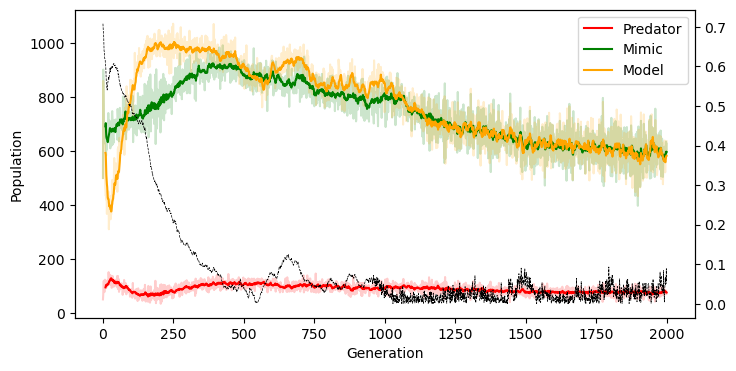

In [143]:
ax = plot(detectors_history, nv_history, signals_history)
plot_overlap(detectors_history, signals_history, ax=ax)

In [ ]:
steps_per_frame = 1
fig = plt.figure(figsize=(4,4))
ax = plt.axes(xlim=(-5, 5), ylim=(-5, 5))

def animate(i):
    # Remove old points
    for artist in ax.get_lines()+ax.collections:
        artist.remove()

    t = i * steps_per_frame
    num_venomous_prey = nv_history[t]
    pts = []
    ax.scatter(detectors_history[t][ :, 0], detectors_history[t][ :, 1], color='red', label='predators detectors', s=0.2)
    ax.scatter(signals_history[t][ :num_venomous_prey, 0], signals_history[t][ :num_venomous_prey, 1], color='orange', label='venomous signals', s=0.2, alpha=0.5)
    ax.scatter(signals_history[t][ num_venomous_prey:, 0], signals_history[t][ num_venomous_prey:, 1], color='green', label='mimic signals', s=0.2, alpha=0.5)

    return ax.collections

anim = animation.FuncAnimation(fig, animate, 
                               frames=len(detectors_history)//steps_per_frame, 
                               interval=50, blit=True)
plt.close()
anim.save('test.gif')
HTML(anim.to_jshtml())